In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import os
sys.path.append('../../')
import topovelo as tpv
import matplotlib
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
data_path = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation'
figure_path = '/nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/simulation'
model_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/checkpoints'

In [3]:
adata = anndata.read_h5ad(f'{data_path}/bilinear.h5ad')

In [4]:
scv.pp.normalize_per_cell(adata, enforce=True)
scv.pp.log1p(adata)

sc.pp.pca(adata)
scv.pp.neighbors(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.umap(adata)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
sc.tl.leiden(adata, key_added='clusters')

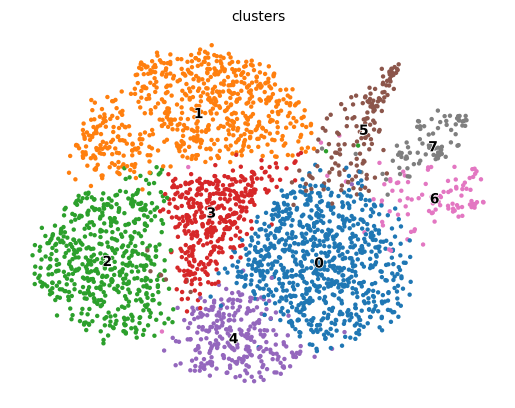

In [6]:
scv.pl.scatter(adata)

saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/simulation/bilinear_cluster.pdf


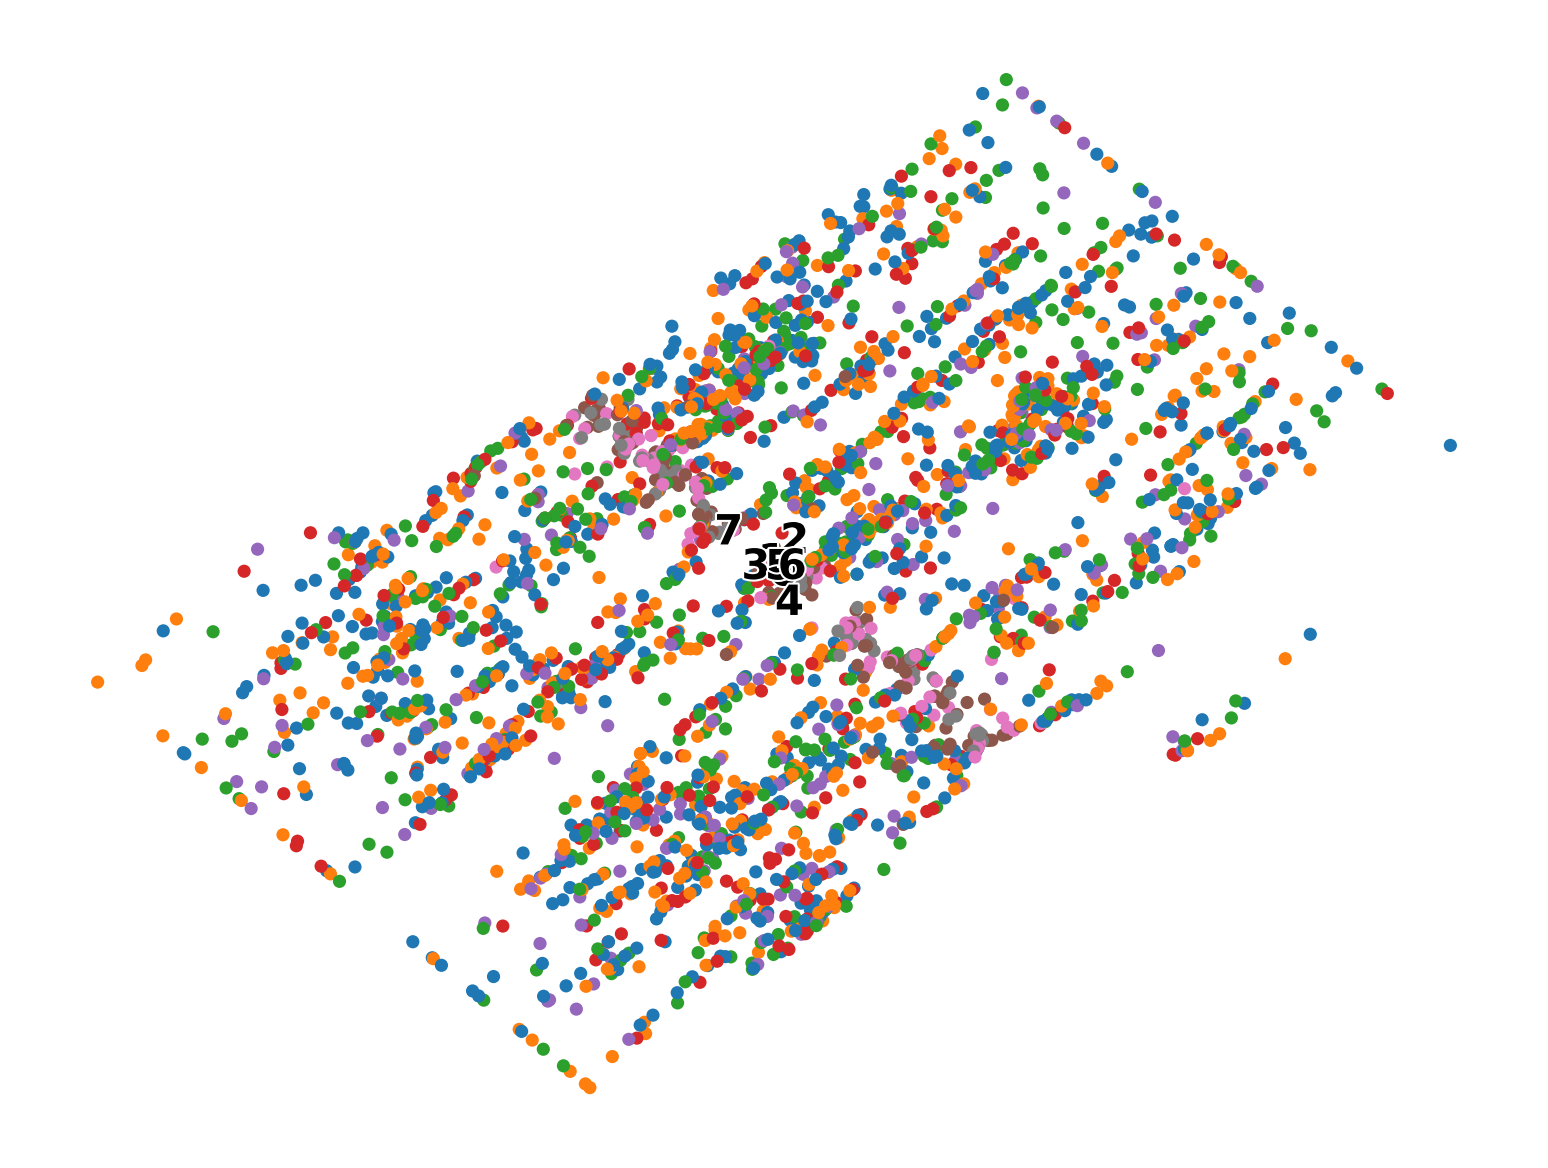

In [7]:
scv.pl.scatter(adata, basis='spatial', title='', save=f'{figure_path}/bilinear_cluster.pdf', dpi=300)

# TopoVelo

In [8]:
from sklearn.neighbors import NearestNeighbors
X_pos = adata.obsm['X_spatial']
nn = NearestNeighbors(n_neighbors=16)
nn.fit(X_pos)
adata.obsp['spatial_graph'] = nn.kneighbors_graph()

In [9]:
model_path = f'{model_path_base}/linear'
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4,
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          embed='spatial')
vae.save_model(f'{model_path}/linear', 'encoder_tpv', 'decoder_tpv')
vae.save_anndata(adata, 'tpv', data_path, file_name="bilinear_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/500 [00:00<?, ?it/s]

Detected 217 velocity genes.
Estimating the variance...


  0%|          | 0/500 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 2. 1.]
Initial induction: 333, repression: 167/500
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/500 [00:00<?, ?it/s]

--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/3000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.036
Average Neighborhood Size: 146.5
Average Set Size: 17.2
Summary: 
Train ELBO = 470.794
Test ELBO = 548.490
Total Time =   0 h :  6 m :  8 s

*********       Round 1: Early Stop Triggered at epoch 1077.       *********
Change in noise variance: 0.4356
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 572.484
Test ELBO = 567.650
Total Time =   0 h :  6 m : 13 s

*********       Round 2: Early Stop Triggered at epoch 1094.       *********
Change in noise variance: 0.0027
Change in x0: 0.2661
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 543.819
Test ELBO = 567.510
Total Time =   0 h :  6 m : 15 s

*********       Round 3: Early Stop Triggered at epoch 1102.       *********
Change in noise variance: 0.0002
Change in x0: 0.1853
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 619.594
Test ELBO = 563.365
Total Time = 

In [10]:
model_path = f'{model_path_base}/bilinear'
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4,
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          embed='spatial')
vae.save_model(f'{model_path}/linear', 'encoder_gat', 'decoder_gat')
vae.save_anndata(adata, 'gat', data_path, file_name="bilinear_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/500 [00:00<?, ?it/s]

Detected 217 velocity genes.
Estimating the variance...


  0%|          | 0/500 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 2. 1.]
Initial induction: 333, repression: 167/500
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/500 [00:00<?, ?it/s]

--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 383.       *********
Summary: 
Train ELBO = -29.876
Test ELBO = -51.709
Total Time =   0 h : 10 m : 30 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/3000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.032
Average Neighborhood Size: 146.5
Average Set Size: 18.4
Summary: 
Train ELBO = 497.588
Test ELBO = 543.278
Total Time =   0 h : 12 m : 48 s

*********       Round 1: Early Stop Triggered at epoch 478.       *********
Change in noise variance: 0.4491
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 568.630
Test ELBO = 556.854
Total Time =   0 h : 13 m :  5 s

*********       Round 2: Early Stop Triggered at epoch 490.       *********
Change in noise variance: 0.0027
Change in x0: 0.2124
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 525.668
Test ELBO = 555.496
Total Time =   0 h : 13 m : 29 s

*********       Round 3: Early Stop Triggered at epoch 507.       *********
Change in noise variance: 0.0003
Change in x0: 0.1984
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 576.756
Test ELBO = 550.371
Total Time =   0

# VeloVAE

In [11]:
sys.path.insert(1, '../../../velovae')
import velovae as vv
import torch

In [12]:
model_path = f'{model_path_base}/bilinear'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4,
}
vae.train(adata, config=config, plot=False, figure_path=figure_path, embed='spatial')
vae.save_model(model_path, 'encoder_vv', 'decoder_vv')
vae.save_anndata(adata, 'vv', data_path, file_name="bilinear_out.h5ad")

Estimating ODE parameters...


  0%|          | 0/500 [00:00<?, ?it/s]

Detected 217 velocity genes.
Estimating the variance...


  0%|          | 0/500 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/500 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 2. 1.]
Initial induction: 333, repression: 167/500
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 17, test iteration: 32
*********       Stage 1: Early Stop Triggered at epoch 780.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/3000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.032
Average Set Size: 60
*********     Round 1: Early Stop Triggered at epoch 1065.    *********
Change in noise variance: 0.4736
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1137.    *********
Change in noise variance: 0.0027
Change in x0: 0.3151
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1149.    *********
Change in noise variance: 0.0002
Change in x0: 0.2311
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1244.    *********
Change in noise variance: 0.0000
Change in x0: 0.1643
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1267.    *********
Change in noise variance: 0.0000
Change in x0: 0.1170
*********             Velocity Refinement Round 

In [13]:
model_path = f'{model_path_base}/bilinear'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0',
             full_vb=True,
             reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4,
}
vae.train(adata, config=config, plot=False, figure_path=figure_path, embed='spatial')
vae.save_model(model_path, 'encoder_fullvb', 'decoder_fullvb')
vae.save_anndata(adata, 'fullvb', data_path, file_name="bilinear_out.h5ad")

Estimating ODE parameters...


  0%|          | 0/500 [00:00<?, ?it/s]

Detected 217 velocity genes.
Estimating the variance...


  0%|          | 0/500 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/500 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 2. 1.]
Initial induction: 333, repression: 167/500
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 17, test iteration: 32
*********       Stage 1: Early Stop Triggered at epoch 518.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/3000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.032
Average Set Size: 60
*********     Round 1: Early Stop Triggered at epoch 656.    *********
Change in noise variance: 0.4613
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 687.    *********
Change in noise variance: 0.0031
Change in x0: 0.2962
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 736.    *********
Change in noise variance: 0.0004
Change in x0: 0.2641
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 750.    *********
Change in noise variance: 0.0000
Change in x0: 0.2423
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 767.    *********
Change in noise variance: 0.0000
Change in x0: 0.2228
*********             Velocity Refinement Round 6    

# scVelo

In [14]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

recovering dynamics (using 8/32 cores)


  0%|          | 0/235 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [15]:
adata.obs['tprior'] = adata.obs['true_time'].to_numpy()
adata.write_h5ad(f'{data_path}/bilinear_out.h5ad')

# Manually assign cell types

In [3]:
adata = anndata.read_h5ad(f'{data_path}/bilinear_out.h5ad')

In [16]:
n_type = 5
t = adata.obs['true_time'].to_numpy()
tmax, tmin = t.max(), t.min()
delta_t = (tmax - tmin) / n_type
cell_labels = np.array(['0']*adata.n_obs)
for i in range(4):
    cell_labels[(t >= tmin+delta_t*i) & (t <  tmin+delta_t*(i+1))] = str(i)
cell_labels[t >= tmin+delta_t*4] = '4'
print(np.unique(cell_labels))
adata.obs['clusters'] = cell_labels

['0' '1' '2' '3' '4']


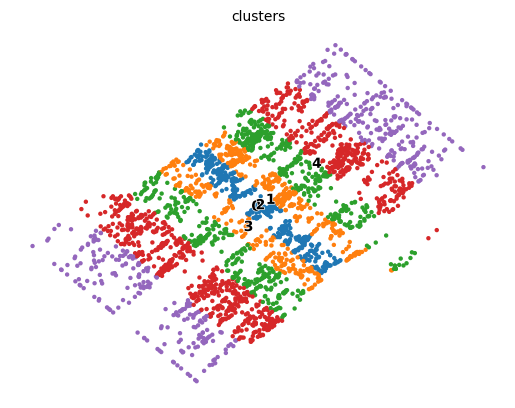

In [17]:
scv.pl.scatter(adata, basis='spatial')

# Evaluation

In [18]:
cluster_edges = [('0', '1'),
                 ('1', '2'),
                 ('2', '3'),
                 ('3', '4')]
(res, res_type,
 res_multi, res_multi_type) = tpv.post_analysis(adata,
                                                'bilinear',
                                                ['scVelo', 'VeloVAE', 'VeloVAE (Rate Prior)', 'TopoVelo (GCN)', 'TopoVelo (GAT)'],
                                                ['fit', 'vv', 'fullvb', 'tpv', 'gat'],
                                                spatial_graph_key='spatial_graph',
                                                spatial_key='X_spatial',
                                                compute_metrics=True,
                                                genes=np.random.choice(adata.var_names, 4),
                                                grid_size=(1, 4),
                                                embed='spatial',
                                                plot_type=[],
                                                cluster_edges=cluster_edges)

*** Computing performance metrics 1/5 ***
computing velocity graph (using 1/32 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 2/5 ***
computing velocity graph (using 1/32 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 3/5 ***
computing velocity graph (using 1/32 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 4/5 ***
computing velocity graph (using 1/32 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 5/5 ***
computing velocity graph (using 1/32 cores)


  0%|          | 0/3000 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

---     Integrating Peformance Metrics     ---
Dataset Size: 3000 cells, 500 genes
---   Plotting  Results   ---


In [21]:
perf_logger = tpv.PerfLogger(save_path='/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/perf')
perf_logger.insert('Bidirectional', res, res_type, res_multi, res_multi_type)

In [22]:
perf_logger.df.loc[['Time Correlation', 'Spatial Velocity Consistency', 'Spatial Time Consistency', 'CBDir']]

Dataset                                            Bidirectional
Metrics                      Model                              
Time Correlation             scVelo                        0.428
                             VeloVAE                       0.895
                             VeloVAE (Rate Prior)          0.908
                             TopoVelo (GCN)                0.950
                             TopoVelo (GAT)                0.990
Spatial Velocity Consistency scVelo                        0.372
                             VeloVAE                       0.859
                             VeloVAE (Rate Prior)          0.891
                             TopoVelo (GCN)                0.973
                             TopoVelo (GAT)                0.987
Spatial Time Consistency     scVelo                        0.471
                             VeloVAE                       0.866
                             VeloVAE (Rate Prior)          0.865
                             TopoVelo (GCN)                0.965
                             TopoVelo (GAT)                0.990
CBDir                        scVelo                        0.279
                             VeloVAE                       0.756
                             VeloVAE (Rate Prior)          0.767
                             TopoVelo (GCN)                0.767
                             TopoVelo (GAT)                0.767

In [23]:
perf_logger.save('simulation')